## TP5: Topic Modeling 

In [ ]:
import gensim
import numpy as np
import pandas as pd
import spacy
from spacy import displacy
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt

In [ ]:
import warnings
import os
warnings.filterwarnings('ignore')
%matplotlib inline

The latest hot topic in the news is fake news and many are wondering what data scientists can do to detect it and stymie its viral spread. This dataset is only a first step in understanding and tackling this problem. It contains text and metadata scraped from 244 websites tagged as "bullshit" by the BS Detector Chrome Extension by Daniel Sieradski.
[Fake News Dataset](https://www.kaggle.com/datasets/mrisdal/fake-news/)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fake.csv to fake.csv


In [ ]:
df = pd.read_csv("fake.csv")
df.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


# Data Processing and Cleaning

I limited the sample size to 200 because when i took the whole document and used nlp(text) it said that there's a limit of characters that can be used

In [ ]:
`text_column_name = 'text'

# Limit to the first 200 rows
sample_size = 200
text = ' '.join(df.sample(sample_size)[text_column_name].astype(str))


In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

For safe measure, let's add some stopwords. It's a newpaper corpus, so it is likely that we will be coming across variations of 'said' and 'Mister' which will not really add any value to the topic models.

In [ ]:
stop_words = [u'say', u'\'s', u'Mr', u'be', u'said', u'says', u'saying']
for stopword in stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [ ]:
doc = nlp(text)


In [ ]:
doc

[Print They should pay all the back all the money plus interest. The entire family and everyone who came in with them need to be deported asap. Why did it take two years to bust them? 
 Here we go again …another group stealing from the government and taxpayers! A group of Somalis stole over four million in government benefits over just 10 months! 
 We’ve reported on numerous cases like this one where the Muslim refugees/immigrants commit fraud by scamming our system…It’s way out of control! More Related,
 Why Did Attorney General Loretta Lynch Plead The Fifth? Barracuda Brigade 2016-10-28 Print The administration is blocking congressional probe into cash payments to Iran. Of course she needs to plead the 5th. She either can’t recall, refuses to answer, or just plain deflects the question. Straight up corruption at its finest! 
 100percentfedUp.com ; Talk about covering your ass! Loretta Lynch did just that when she plead the Fifth to avoid incriminating herself over payments to Iran…Co

In [ ]:
# we add some words to the stop word list
texts, article, skl_texts = [], [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        skl_texts.append(' '.join(article))
        texts.append(article)
        article = []

In [ ]:
bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)
texts_with_bigrams = [bigram[line] for line in texts]

# Print the first 10 words of the second document after adding bigrams
print(texts_with_bigrams[1][0:10])


['Gore', 'Vidal', 'get', 'laugh', 'year', 'ago', 'refer', 'Ronald', 'Reagan', 'acting']


In [ ]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel


# LSI

In [ ]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)


In [ ]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics


[(0,
  '0.665*"Retired" + 0.394*"General" + 0.265*"Admiral" + 0.240*"Navy" + 0.216*"Rear" + 0.211*"Air" + 0.211*"Force" + 0.189*"Major" + 0.158*"Army" + 0.108*"Brigadier"'),
 (1,
  '0.441*"Clinton" + 0.250*"Monsanto" + 0.184*"Hillary" + 0.171*"Trump" + 0.149*"email" + 0.134*"case" + 0.128*"government" + 0.124*"year" + 0.123*"Obama" + 0.122*"people"'),
 (2,
  '-0.293*"Clinton" + 0.225*"Trump" + 0.209*"jewish" + -0.196*"Monsanto" + 0.191*"Mars" + 0.181*"image" + 0.160*"Jews" + 0.157*"rover" + 0.145*"Greenberg" + 0.134*"alien"'),
 (3,
  '0.266*"body" + 0.251*"man" + -0.159*"jewish" + 0.158*"soul" + 0.156*"human" + 0.155*"consciousness" + 0.155*"conscious" + -0.142*"Mars" + 0.141*"high" + 0.139*"world"'),
 (4,
  '-0.399*"Trump" + 0.186*"Monsanto" + -0.154*"election" + -0.131*"vote" + 0.130*"jewish" + -0.128*"people" + -0.128*"U.S." + -0.118*"report" + 0.116*"Mars" + 0.114*"image"')]

# LDA

In [ ]:
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10,iterations=500,passes=50)

In [ ]:
lda_model.show_topics(num_topics=5)

[(7,
  '0.010*"trade" + 0.009*"article" + 0.009*"country" + 0.007*"long" + 0.006*"european" + 0.006*"free" + 0.006*"result" + 0.005*"gun" + 0.005*"world" + 0.004*"Primacy"'),
 (9,
  '0.009*"Saudi" + 0.009*"right" + 0.009*"Arabia" + 0.008*"people" + 0.007*"water" + 0.005*"kind" + 0.004*"Wahhabism" + 0.004*"Islam" + 0.004*"world" + 0.004*"look"'),
 (4,
  '0.030*"Retired" + 0.020*"General" + 0.012*"Admiral" + 0.011*"Navy" + 0.011*"Force" + 0.010*"Air" + 0.010*"Rear" + 0.008*"Major" + 0.008*"Army" + 0.007*"farm"'),
 (2,
  '0.008*"chicken" + 0.007*"people" + 0.007*"Salmonella" + 0.006*"know" + 0.005*"area" + 0.005*"correspondence" + 0.004*"live" + 0.004*"avoid" + 0.004*"plant" + 0.004*"vegetable"'),
 (8,
  '0.016*"credit" + 0.006*"de" + 0.005*"government" + 0.005*"die" + 0.005*"Maryamiyyah" + 0.005*"american" + 0.004*"Nasr" + 0.004*"system" + 0.004*"Schuon" + 0.004*"member"')]

# HDP

In [ ]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics()


[(0,
  '0.014*Retired + 0.009*General + 0.006*Admiral + 0.005*Navy + 0.005*Rear + 0.005*Air + 0.005*Force + 0.004*Major + 0.003*Army + 0.003*people + 0.003*Trump + 0.003*Clinton + 0.003*world + 0.002*Hillary + 0.002*Brigadier + 0.002*Lieutenant + 0.002*know + 0.002*John + 0.002*come + 0.002*think'),
 (1,
  '0.004*Trump + 0.002*Clinton + 0.002*year + 0.002*Hillary + 0.002*election + 0.001*government + 0.001*report + 0.001*medium + 0.001*United + 0.001*email + 0.001*go + 0.001*States + 0.001*dollar + 0.001*life + 0.001*support + 0.001*long + 0.001*America + 0.001*change + 0.001*plan + 0.001*american'),
 (2,
  '0.004*Clinton + 0.002*Monsanto + 0.002*Hillary + 0.001*email + 0.001*investigation + 0.001*Comey + 0.001*FBI + 0.001*case + 0.001*Trump + 0.001*government + 0.001*state + 0.001*Obama + 0.001*criminal + 0.001*time + 0.001*people + 0.001*Russia + 0.001*crime + 0.001*Justice + 0.001*close + 0.001*law'),
 (3,
  '0.001*jewish + 0.001*Trump + 0.001*Mars + 0.001*Jews + 0.001*alien + 0.001

# Comparing the three models :
Topic coherence is a complex topic in its own and it can be used to measure the quality of topic models to some extent. Typically, a set of statements is said to be coherent if they support each other. Topic models are unsupervised learning based models that are trained on unstructured text data, making it difficult to measure the quality of outputs.

In [ ]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in lda_model.show_topics(formatted=False)]

In [ ]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [ ]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.

    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

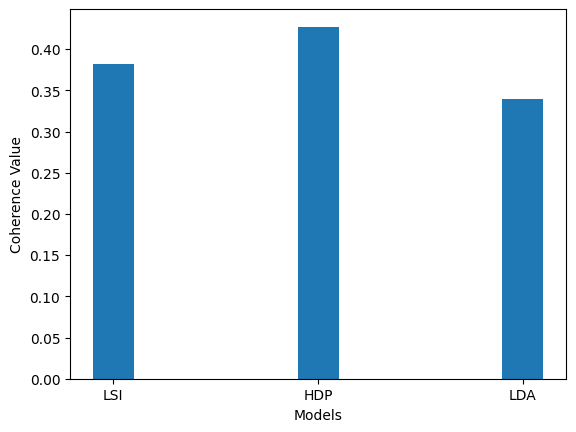

In [ ]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])